In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Установка переменной окружения для предотвращения предупреждений о количестве ядер
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

# Загрузка данных
train = pd.read_csv('train_oil.csv')
test = pd.read_csv('test_oil.csv')

# Сохранение столбца 'Field name' для тестовых данных
test_field_name = test['Field name'].reset_index(drop=True)

# Идентификация категориальных и числовых признаков
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Удаление целевой переменной из категориальных признаков
if 'Onshore/Offshore' in categorical_cols:
    categorical_cols.remove('Onshore/Offshore')

# Заполнение пропущенных значений для числовых признаков
train[numerical_cols] = train[numerical_cols].fillna(train[numerical_cols].mean())
test[numerical_cols] = test[numerical_cols].fillna(train[numerical_cols].mean())

# Заполнение пропущенных значений для категориальных признаков
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])
test[categorical_cols] = test[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

# Преобразование целевой переменной в числовые значения
label_encoder = LabelEncoder()
train['Onshore/Offshore'] = label_encoder.fit_transform(train['Onshore/Offshore'])

# Преобразование категориальных признаков с помощью OneHotEncoder
try:
    # Для scikit-learn версии 1.2.0 и выше
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # Для более старых версий scikit-learn
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Фитим энкодер на тренировочных данных
encoder.fit(train[categorical_cols])

# Преобразуем тренировочные и тестовые данные
train_encoded = encoder.transform(train[categorical_cols])
test_encoded = encoder.transform(test[categorical_cols])

# Создаем DataFrame из закодированных признаков
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=test.index)

# Удаляем оригинальные категориальные признаки
train.drop(columns=categorical_cols, inplace=True)
test.drop(columns=categorical_cols, inplace=True)

# Объединяем закодированные признаки с остальными признаками
train = pd.concat([train, train_encoded_df], axis=1)
test = pd.concat([test, test_encoded_df], axis=1)

# Разделение данных на признаки и целевую переменную
X_train = train.drop(['Onshore/Offshore'], axis=1)
y_train = train['Onshore/Offshore']
X_test = test

# Разделение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Подбор гиперпараметров для KNN с использованием RandomizedSearchCV
param_dist_knn = {
    'n_neighbors': np.arange(5, 25, 2),  # Увеличение диапазона соседей
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                       param_distributions=param_dist_knn,
                                       n_iter=50,  # Количество комбинаций для проверки
                                       cv=2,       # Количество фолдов в кросс-валидации
                                       scoring='f1_macro',  # Используем F1-score
                                       n_jobs=-1,  # Параллелизация на всех ядрах
                                       random_state=42)

random_search_knn.fit(X_train, y_train)

best_knn = random_search_knn.best_estimator_
print("Best KNN Parameters:", random_search_knn.best_params_)

# Сравнение моделей
y_pred_best_knn = best_knn.predict(X_val)
print("Best KNN Validation Accuracy:", accuracy_score(y_val, y_pred_best_knn))
print("Best KNN Validation F1 Score:", f1_score(y_val, y_pred_best_knn, average='macro', zero_division=0))
print(classification_report(y_val, y_pred_best_knn, zero_division=0))

# Подбор гиперпараметров для Логистической Регрессии с использованием RandomizedSearchCV
param_dist_lr = {
    'C': np.logspace(-3, 3, 10),
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']  # Добавление учета несбалансированности классов
}

random_search_lr = RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                                       param_distributions=param_dist_lr,
                                       n_iter=50,  # Количество комбинаций для проверки
                                       cv=2,       # Количество фолдов в кросс-валидации
                                       scoring='f1_macro',  # Используем F1-score
                                       n_jobs=-1,  # Параллелизация на всех ядрах
                                       random_state=42)

random_search_lr.fit(X_train, y_train)

best_lr = random_search_lr.best_estimator_
print("Best Logistic Regression Parameters:", random_search_lr.best_params_)

# Сравнение моделей
y_pred_best_lr = best_lr.predict(X_val)
print("Best Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_pred_best_lr))
print("Best Logistic Regression Validation F1 Score:", f1_score(y_val, y_pred_best_lr, average='macro', zero_division=0))
print(classification_report(y_val, y_pred_best_lr, zero_division=0))

# Предсказание на тестовых данных
y_pred_test_knn = best_knn.predict(X_test)
y_pred_test_lr = best_lr.predict(X_test)

# Проверка формата предсказаний
print("Unique predicted values (KNN):", np.unique(y_pred_test_knn))
print("Unique predicted values (Logistic Regression):", np.unique(y_pred_test_lr))

# Создаем DataFrame для сабмита KNN
submission_knn = pd.DataFrame({
    'index': range(len(y_pred_test_knn)),  # Индексы тестовых данных
    'Onshore/Offshore': y_pred_test_knn  # Предсказания модели KNN
})

# Создаем DataFrame для сабмита Logistic Regression
submission_lr = pd.DataFrame({
    'index': range(len(y_pred_test_lr)),  # Индексы тестовых данных
    'Onshore/Offshore': y_pred_test_lr  # Предсказания модели Logistic Regression
})

# Сохраняем файлы сабмита
submission_knn.to_csv('submission_knn.csv', index=False)
submission_lr.to_csv('submission_lr.csv', index=False)

Best KNN Parameters: {'weights': 'distance', 'n_neighbors': np.int64(5), 'metric': 'manhattan'}
Best KNN Validation Accuracy: 0.7419354838709677
Best KNN Validation F1 Score: 0.4474053295932679
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.78      0.88      0.83        43
           2       0.00      0.00      0.00         1

    accuracy                           0.74        62
   macro avg       0.46      0.44      0.45        62
weighted avg       0.72      0.74      0.72        62

Best Logistic Regression Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': np.float64(0.46415888336127775)}
Best Logistic Regression Validation Accuracy: 0.8870967741935484
Best Logistic Regression Validation F1 Score: 0.5816259087904825
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.89      0.95      0.92     

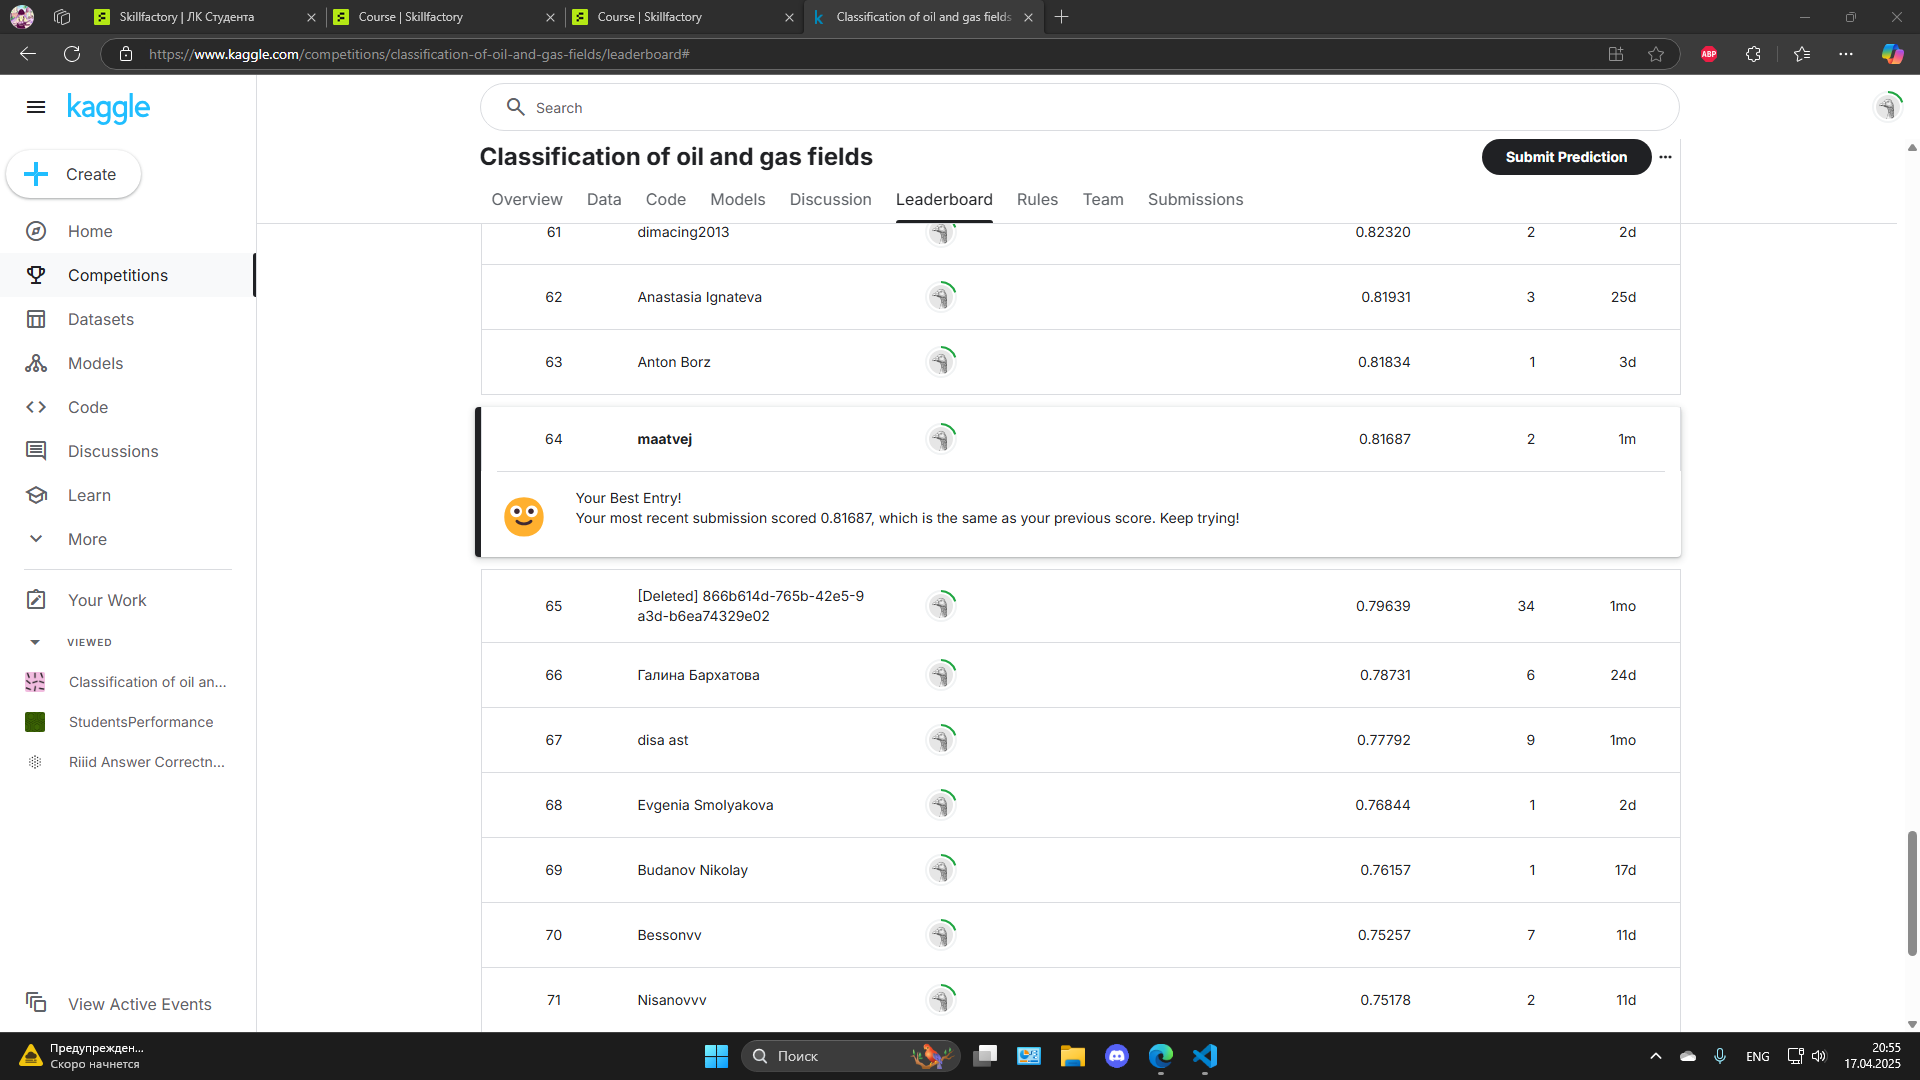